In [1]:
import functools
import torch
from torch.nn.functional import softmax
import torch

import numpy as np
import os
import pandas as pd
import transformers
import torch


from scipy.spatial.distance import cosine
from tqdm import tqdm
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AutoModelForCausalLM
import statsmodels.formula.api as smf

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
def generate_revisions():
    ## TODO: Ensure this is correct
    # Fixed initial steps
    revisions = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000]
    # Add every 1,000 steps afterward
    revisions.extend(range(2000, 144000, 1000))  # Adjust range as needed
    # Format each step as "stepX"
    return [f"step{step}" for step in revisions]

revisions = generate_revisions()
revisions[0:3]

['step0', 'step1', 'step2']

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
# Parameters
layer_idx = 2 
head_idx = 1

In [5]:
### NOTES
### A Given attention head's QKV matrix has shape (3 * hidden_size, hidden_size)
### QKV split into thirds (Q, K, V)
### And each matrix (e.g., Q) is split into number of heads (e.g., 4)

In [7]:
def get_QKV(model, layer_idx, head_idx):

    ### Get hidden size and num_heads
    hidden_size = model.config.hidden_size
    num_heads = model.config.num_attention_heads

    ### Figure out head_dim
    head_dim = hidden_size // num_heads

    # Get start/end of target head
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim

    # Extract the attention mechanism for the desired layer
    attention = model.gpt_neox.layers[layer_idx].attention

    ### Get QKV
    query_weight = attention.query_key_value.weight[:hidden_size, :]
    key_weight = attention.query_key_value.weight[hidden_size:2*hidden_size, :]
    value_weight = attention.query_key_value.weight[2*hidden_size:, :]

    ### Get specific heads
    query_weight_head = query_weight[start:end, :]
    key_weight_head = key_weight[start:end, :]
    value_weight_head = value_weight[start:end, :]

    return {'Q': query_weight_head, 
            'K': key_weight_head,
            'V': value_weight_head}

In [8]:
model.gpt_neox.layers[2].attention.query_key_value.weight

NameError: name 'model' is not defined

In [ ]:
def compute_id(X, ratio=.95):

    # Assuming `query_weight_head` is a NumPy array or can be converted to one
    pca = PCA()
    pca.fit(X.detach().numpy())
    
    # Explained variance ratios
    explained_variance_ratios = pca.explained_variance_ratio_
    
    # Find the number of components that explain 95% of variance
    cumulative_variance = explained_variance_ratios.cumsum()
    n_components_ratio = (cumulative_variance < ratio).sum() + 1

    return {'n_components': n_components_ratio,
            'prop_components': n_components_ratio / X.shape[0]}

In [25]:
mpath = "EleutherAI/pythia-70m-seed9"


In [26]:
### if it doesn't exist, run it.
model = GPTNeoXForCausalLM.from_pretrained(
    mpath,
    # revision="step2000/seed-1",
    revision = "step2000",
    output_hidden_states = True
)

tokenizer = AutoTokenizer.from_pretrained(mpath, revision="step143000")

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/166M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
### TODO: Calculate changes in weights

In [12]:
model.gpt_neox.layers[3].attention.query_key_value.weight.shape

torch.Size([384, 128])

### Ablation

**NOTES SO FAR**:

In first pass, I was modifying `outputs[0]`. This modifies the *output* of attention but will not modify the scores themselves.

Other options:

- modify `outputs[1]` (but how to propagate to attention output?)
- modify QKV directly?

In [7]:


def get_attention_and_entropy_for_head(
    attentions, inputs, tokenizer, target, disambiguating, layer, head, device
):
    """
    Get entropy over attention from a target token to all tokens,
    and the attention from a target token to a specific disambiguating token
    for a specified head in a given layer.
    
    Args:
        model: Pretrained Transformer model.
        tokenizer: Corresponding tokenizer.
        sentence (str): Input sentence.
        target (str): Target word.
        disambiguating (str): Disambiguating word.
        layer (int): Layer index for attention extraction.
        head (int): Head index for attention extraction.
        device (str): Device to run computations on (e.g., 'cpu', 'cuda').
    
    Returns:
        dict: Contains entropy of attention distribution, attention to disambiguating token, 
              and attention distribution.
    """
    # Tokenize target and disambiguating words
    target_enc = tokenizer.encode(target, return_tensors="pt", add_special_tokens=False).to(device)
    disambiguating_enc = tokenizer.encode(disambiguating, return_tensors="pt", add_special_tokens=False).to(device)
    
    # Find indices of target and disambiguating words in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )
    disambiguating_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        disambiguating_enc[0].tolist()
    )
    
    if target_inds is None:
        raise ValueError(f"Target word '{target}' not found in the tokenized input.")
    if disambiguating_inds is None:
        raise ValueError(f"Disambiguating word '{disambiguating}' not found in the tokenized input.")
    
    # Extract attention from the specified layer
    attention_layer = attentions[layer][0]  # Shape: (num_heads, seq_len, seq_len)
    
    # Select the specified head
    attention_head = attention_layer[head]  # Shape: (seq_len, seq_len)
    
    # Get attention distribution for the target token(s)
    target_attention = attention_head[target_inds[0]:target_inds[1]]  # Shape: (target_len, seq_len)
    
    # Average over multiple tokens if target spans multiple subwords
    attention_distribution = torch.mean(target_attention, dim=0)  # Shape: (seq_len)
    
    # Calculate entropy over the attention distribution
    attention_probs = softmax(attention_distribution, dim=-1)
    entropy = -torch.sum(attention_probs * torch.log(attention_probs + 1e-12)).item()
    
    # Calculate attention to the disambiguating token(s)
    disambiguating_attention = attention_distribution[
        disambiguating_inds[0]:disambiguating_inds[1]
    ]

    attention_to_disambiguating = torch.mean(disambiguating_attention).item()
    
    return {
        "entropy": entropy,
        "attention_to_disambiguating": attention_to_disambiguating,
        "attention_distribution": attention_distribution
    }


def find_sublist_index(mylist, sublist):
    """Find the first occurence of sublist in list.
    Return the start and end indices of sublist in list"""

    for i in range(len(mylist)):
        if mylist[i] == sublist[0] and mylist[i:i+len(sublist)] == sublist:
            return i, i+len(sublist)
    return None


### ... grab the embeddings for your target tokens
def get_embedding(hidden_states, inputs, tokenizer, target, layer, device):
    """Extract embedding for TARGET from set of hidden states and token ids."""
    
    # Tokenize target
    target_enc = tokenizer.encode(target, return_tensors="pt",
                                  add_special_tokens=False).to(device)
    
    # Get indices of target in input tokens
    target_inds = find_sublist_index(
        inputs["input_ids"][0].tolist(),
        target_enc[0].tolist()
    )

    # Get layer
    selected_layer = hidden_states[layer][0]

    #grab just the embeddings for your target word's token(s)
    token_embeddings = selected_layer[target_inds[0]:target_inds[1]]

    #if a word is represented by >1 tokens, take mean
    #across the multiple tokens' embeddings
    embedding = torch.mean(token_embeddings, dim=0)
    
    return embedding

In [8]:
# Define a custom hook function
def ablate_head_hook(module, inputs, output):
    # Extract the tensor from the output tuple (if necessary)
    if isinstance(output, tuple):
        attention_output = output[0]  # Assuming the first element is the tensor
        # Zero out the specific head
        attention_output[:, :, head_to_ablate] = 0
        print(attention_output[:, :, head_to_ablate])
        return (attention_output,) + output[1:]  # Return modified output as a tuple
    else:
        # If not a tuple, directly modify the tensor
        output[:, :, head_to_ablate] = 0
        return output


In [9]:
def mask_head_hook(module, inputs, output):
    """
    Masks a specific attention head by modifying its attention scores.
    """
    # Extract the main attention output and the nested tuple
    attention_output = output[0]  # Main output
    nested_attention = output[1]  # Tuple of attention-related outputs

    # Extract the attention scores from the nested tuple
    attention_scores = nested_attention[0].clone()  # Clone to make modifiable

    # Mask the specific head
    attention_scores[:, head_to_ablate, :, :] = -1e9  # Large negative value to suppress head

    # Reconstruct the nested tuple with the modified scores
    modified_nested_attention = (attention_scores, nested_attention[1])

    # Return the outputs with the modified nested attention
    return (attention_output, modified_nested_attention)

In [10]:
def ablate_head_inputs_hook(module, inputs, output):
    """
    Ablates a specific attention head by zeroing out its inputs (query, key, or value).
    """
    # Unpack inputs (query, key, value)
    query, key, value = inputs

    # Reshape to isolate heads
    # Assuming query, key, value have shape: [batch_size, seq_len, hidden_dim]
    batch_size, seq_len, hidden_dim = query.shape
    num_heads = module.num_heads
    head_dim = hidden_dim // num_heads

    query = query.view(batch_size, seq_len, num_heads, head_dim)
    key = key.view(batch_size, seq_len, num_heads, head_dim)
    value = value.view(batch_size, seq_len, num_heads, head_dim)

    # Zero out the specific head in the inputs
    query[:, :, head_to_ablate, :] = 0
    key[:, :, head_to_ablate, :] = 0
    value[:, :, head_to_ablate, :] = 0

    # Reshape back to original dimensions
    query = query.view(batch_size, seq_len, hidden_dim)
    key = key.view(batch_size, seq_len, hidden_dim)
    value = value.view(batch_size, seq_len, hidden_dim)

    # Return modified inputs
    return query, key, value

In [50]:
# Choose layer and head to ablate
layer_to_ablate = 2
head_to_ablate = 0

In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
mpath = "EleutherAI/pythia-14m"

In [52]:
### if it doesn't exist, run it.
model = GPTNeoXForCausalLM.from_pretrained(
    mpath,
    revision="step143000",
    output_hidden_states = True
)

tokenizer = AutoTokenizer.from_pretrained(mpath, revision="step143000")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
layer = model.gpt_neox.layers[layer_to_ablate].attention
hook = layer.register_forward_hook(ablate_head_hook)

In [54]:
sentence1 = "She liked the marinated lamb."
sentence2 = "She liked the friendly lamb."
inputs1 = tokenizer(sentence1, return_tensors="pt")
inputs2 = tokenizer(sentence2, return_tensors="pt")

In [55]:
# Run the model to get attentions
with torch.no_grad():
    outputs1 = model(**inputs1, output_attentions = True)
    attentions1 = outputs1.attentions  # List of attention tensors
    hidden_states1 = outputs1.hidden_states

# Run the model to get attentions
with torch.no_grad():
    outputs2 = model(**inputs2, output_attentions = True)
    attentions2 = outputs2.attentions  # List of attention tensors
    hidden_states2 = outputs2.hidden_states

tensor([[0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0.]])


In [56]:
get_attention_and_entropy_for_head(
    attentions1, inputs1, tokenizer, " lamb", " marinated", layer_to_ablate, head_to_ablate, device)

{'entropy': 1.9274141788482666,
 'attention_to_disambiguating': 0.1443759799003601,
 'attention_distribution': tensor([0.0573, 0.0223, 0.0787, 0.1281, 0.1607, 0.5529, 0.0000])}

In [57]:
e1 = get_embedding(hidden_states1, inputs1, tokenizer, " lamb", layer_to_ablate + 1, device)
e2 = get_embedding(hidden_states2, inputs2, tokenizer, " lamb", layer_to_ablate + 1, device)

In [58]:
model_cosine = cosine(e1.cpu(), e2.cpu())
model_cosine

0.09697221525570676

In [153]:
def nested_debug_hook(module, inputs, output):
    print(f"Output[1] type: {type(output[1])}")
    if isinstance(output[1], tuple):
        print(f"Output[1] length: {len(output[1])}")
        for i, o in enumerate(output[1]):
            if isinstance(o, torch.Tensor):
                print(f"Output[1][{i}] shape: {o.shape}")
            else:
                print(f"Output[1][{i}] type: {type(o)}")

In [154]:
debug_hook_handle = layer.register_forward_hook(nested_debug_hook)
outputs = model(**inputs1)  # Run the model to trigger the hook
debug_hook_handle.remove()

Output[1] type: <class 'tuple'>
Output[1] length: 2
Output[1][0] shape: torch.Size([1, 4, 6, 32])
Output[1][1] shape: torch.Size([1, 4, 6, 32])


In [22]:
attentions1[layer_idx][0][head_idx]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.8033e-01, 1.1967e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.2085e-02, 1.9482e-02, 9.6843e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.8149e-05, 1.1454e-01, 7.3389e-01, 1.5150e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0807e-06, 1.5821e-04, 6.2947e-02, 9.0505e-01, 3.1840e-02, 0.0000e+00,
         0.0000e+00],
        [3.7565e-06, 3.5427e-07, 1.7238e-04, 8.8619e-02, 7.8514e-01, 1.2607e-01,
         0.0000e+00],
        [3.7575e-02, 5.6353e-04, 2.6558e-03, 5.8656e-04, 1.1414e-02, 1.7314e-01,
         7.7407e-01]])

In [184]:
target = " beam"
disambiguating = " balance"

In [185]:
get_attention_and_entropy_for_head(
    attentions1, inputs1, tokenizer, target, disambiguating, layer_to_ablate, head_to_ablate, device)

{'entropy': 1.7023757696151733,
 'attention_to_disambiguating': 0.9585038423538208,
 'attention_distribution': tensor([2.1399e-07, 7.9222e-05, 1.7204e-02, 9.5850e-01, 2.4212e-02, 0.0000e+00])}

In [160]:
softmax(torch.tensor([2.1399e-07, 7.9222e-05, 1.7204e-02, 9.5850e-01, 2.4212e-02, 0.0000e+00]))

/var/folders/pn/5zbmv0cj31v6hmyh53njhmdw0000gn/T/ipykernel_28954/3784479488.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor([2.1399e-07, 7.9222e-05, 1.7204e-02, 9.5850e-01, 2.4212e-02, 0.0000e+00]))


tensor([0.1307, 0.1307, 0.1330, 0.3409, 0.1339, 0.1307])

In [29]:
# Parameters
layer_idx = 2 
head_idx = 3

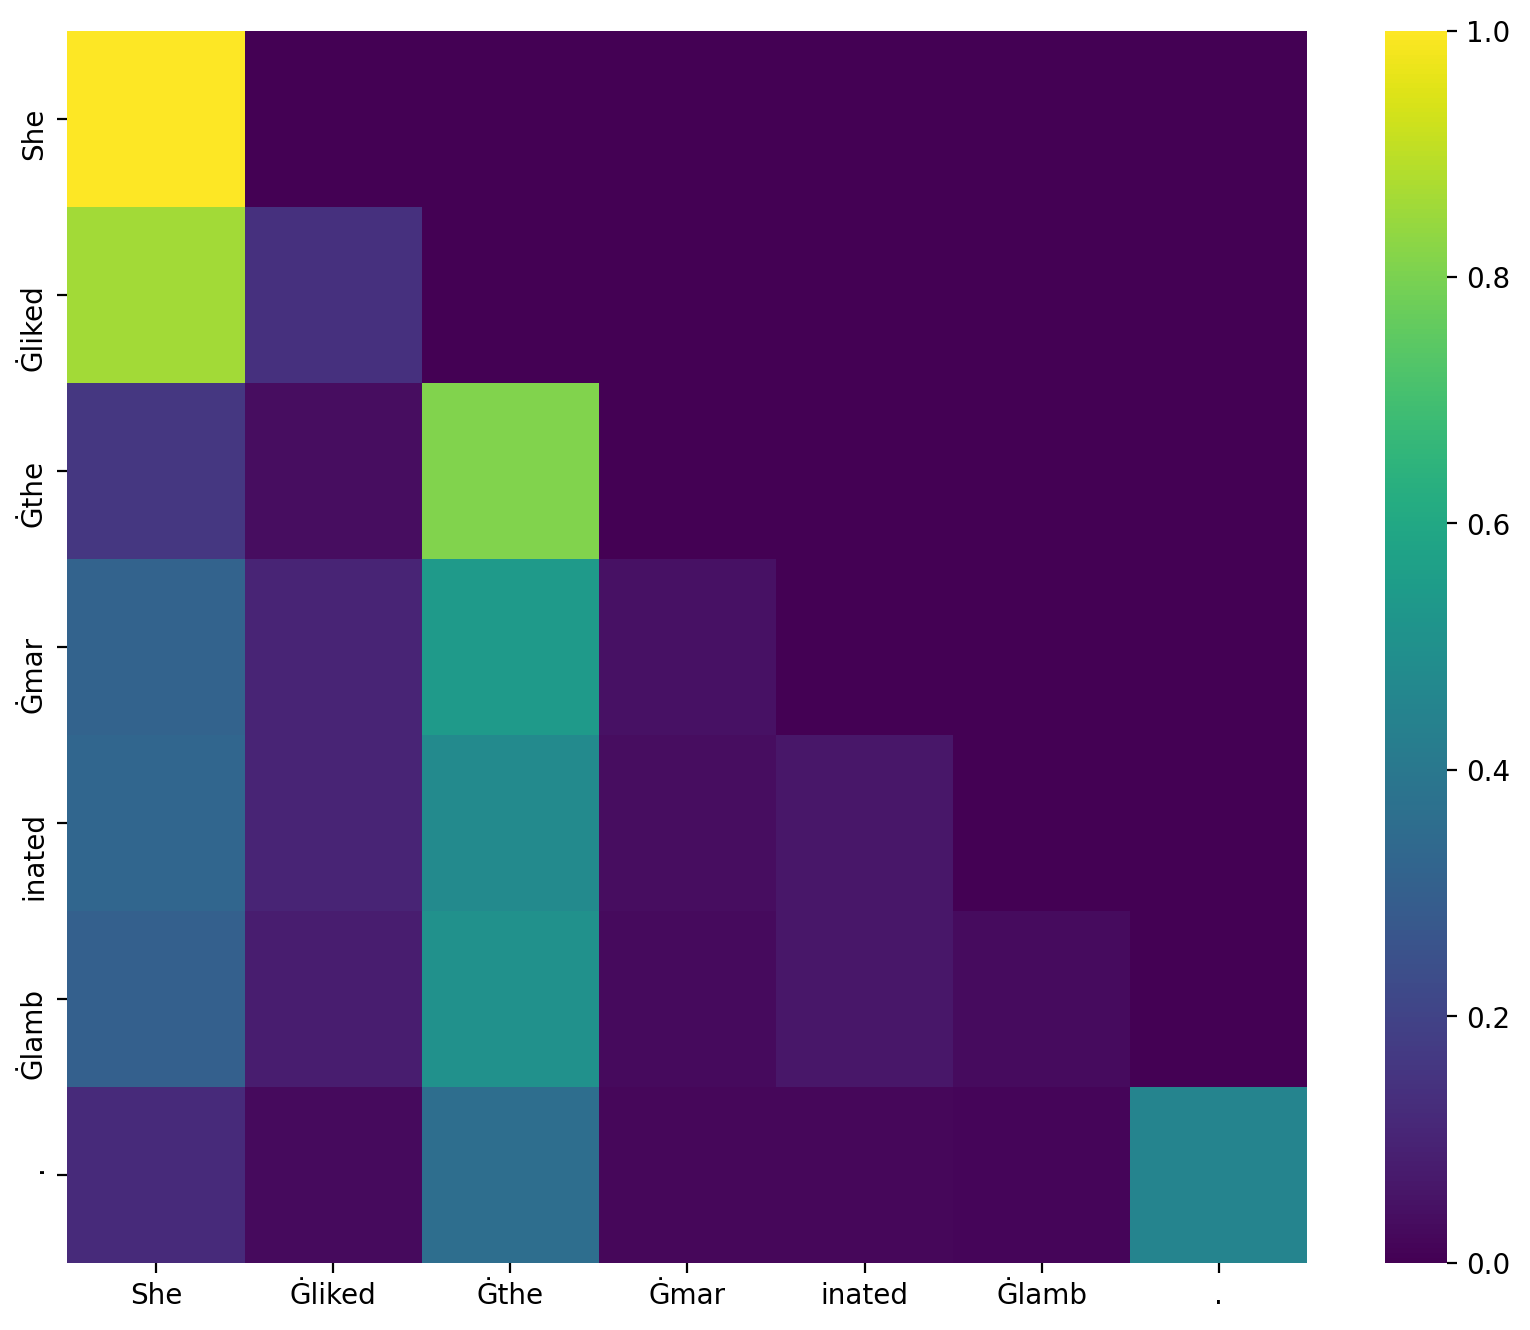

In [30]:
attention_weights = attentions1[layer_idx][0, head_idx, :, :].detach().cpu()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, xticklabels=tokenizer.tokenize(sentence1), yticklabels=tokenizer.tokenize(sentence1), cmap="viridis")
# plt.title(f"Attention Heatmap - Layer {layer_idx + 1}, Head {head_idx + 1}")
# plt.xlabel("Tokens")
# plt.ylabel("Tokens")
plt.show()

### Access weight matrices

In [37]:
results = []
for checkpoint in tqdm(revisions):
    # print("Loading checkpoint: " + checkpoint)

    ### Set up save path, filename, etc.
    savepath = "../data/processed/rawc/pythia/weights/"
    if not os.path.exists(savepath): 
        os.mkdir(savepath)
    if "/" in mpath:
        filename = "weights-model-" + mpath.split("/")[1] + "-" + checkpoint +  ".csv"
    else:
        filename = "weights-model-" + mpath +  "-" + checkpoint + ".csv"

    # print("Checking if we've already run this analysis...")
    if os.path.exists(os.path.join(savepath,filename)):
        print("Already run this model for this checkpoint.")
        continue


    if checkpoint != "step0":
        query_head_past = query_head.clone()

    ### if it doesn't exist, run it.
    model = GPTNeoXForCausalLM.from_pretrained(
        mpath,
        revision=checkpoint
    )
    # model.to(device) # allocate model to desired device

    ### Get head
    QKV = get_QKV(model, layer_idx, head_idx)
    query_head = QKV['Q']
    key_head = QKV['K']

    ### Claculate change
    if checkpoint == "step0":
        change = 0
    else:
        change = torch.norm(query_head - query_head_past, p='fro').item()


    ### Compute PCA
    intrinsic_dim_Q = compute_id(query_head, ratio = .95)
    intrinsic_dim_K = compute_id(key_head, ratio = .95)

    results.append({
        'layer': layer_idx,
        'head': head_idx,
        'query_intrinsic_dim': intrinsic_dim_Q['prop_components'],
        'query_intrinsic_dim_abs': intrinsic_dim_Q['n_components'],
        'query_n_dim': query_head.shape[0],
        'key_intrinsic_dim': intrinsic_dim_K['prop_components'],
        'key_intrinsic_dim_abs': intrinsic_dim_K['n_components'],
        'key_n_dim': key_head.shape[0],
        'revision': checkpoint,
        'step': int(checkpoint.replace("step", "")),
        'query_weight_norm': torch.norm(query_head, p='fro').item(),
        'query_weight_change': change
    })

 61%|█████████████████████████▋                | 94/154 [00:55<00:35,  1.69it/s]


KeyboardInterrupt: 

In [38]:
df_results = pd.DataFrame(results)
df_results.head(3)

,layer,head,query_intrinsic_dim,query_intrinsic_dim_abs,query_n_dim,key_intrinsic_dim,key_intrinsic_dim_abs,key_n_dim,revision,step,query_weight_norm,query_weight_change
0,2,1,0.84375,27,32,0.84375,27,32,step0,0,3.527455,0.000000
1,2,1,0.84375,27,32,0.84375,27,32,step1,1,3.527455,0.000000
2,2,1,0.84375,27,32,0.84375,27,32,step2,2,3.527455,0.000008


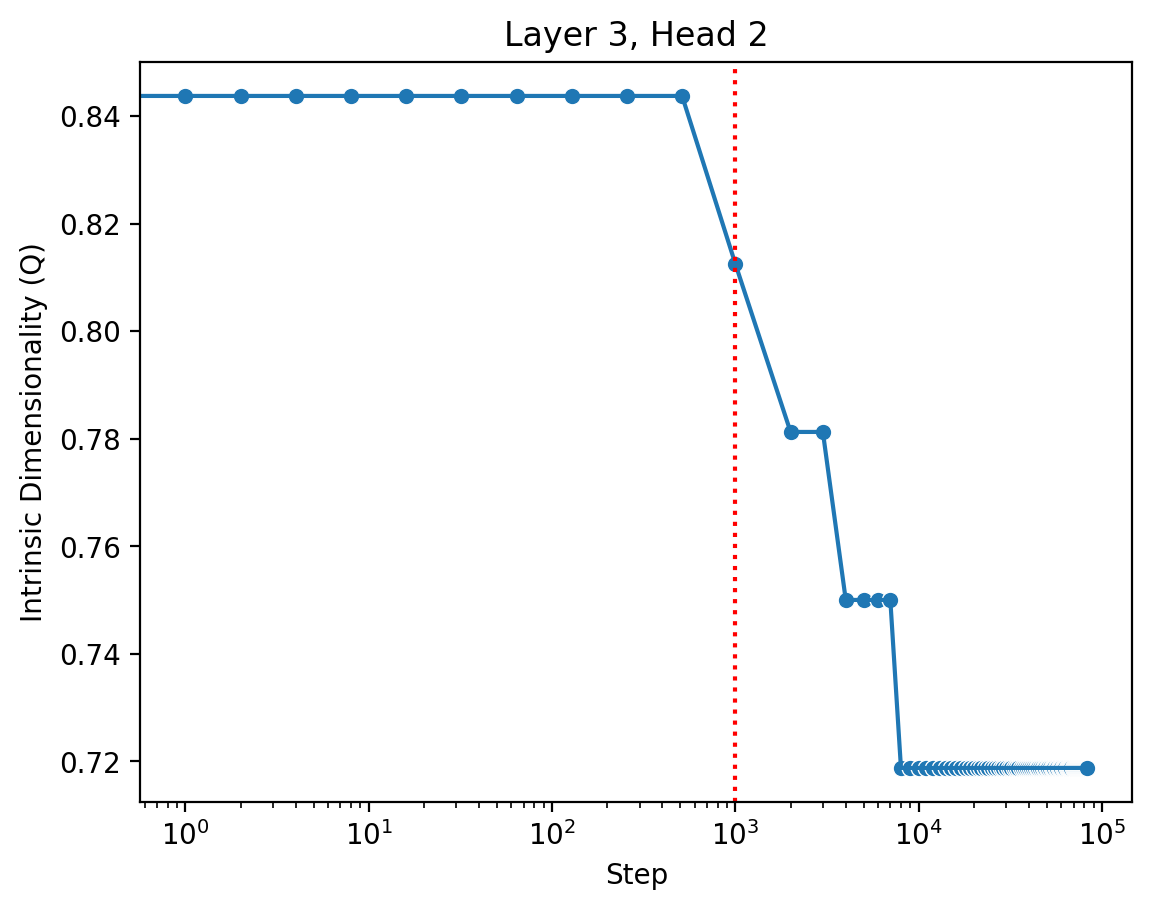

In [39]:
sns.lineplot(data = df_results,
             x = "step", y = "query_intrinsic_dim")
sns.scatterplot(data = df_results,
             x = "step", y = "query_intrinsic_dim")
plt.xscale('log')  # Use 'log' for log10 scaling
plt.title('Layer 3, Head 2')  # Use 'log' for log10 scaling
plt.ylabel("Intrinsic Dimensionality (Q)")
plt.xlabel("Step")
plt.axvline(x=1000, linestyle = "dotted", color = "red")

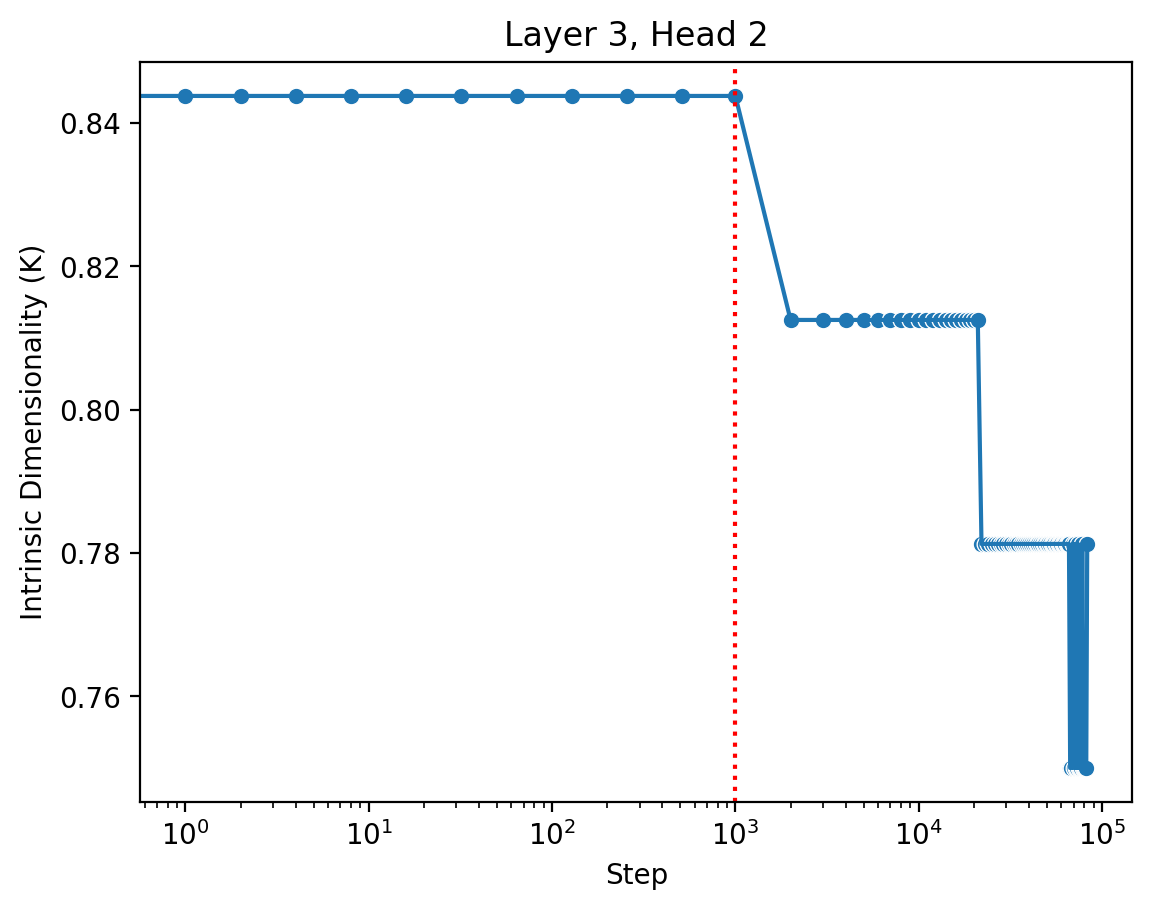

In [40]:
sns.lineplot(data = df_results,
             x = "step", y = "key_intrinsic_dim")
sns.scatterplot(data = df_results,
             x = "step", y = "key_intrinsic_dim")
plt.xscale('log')  # Use 'log' for log10 scaling
plt.title('Layer 3, Head 2')  # Use 'log' for log10 scaling
plt.ylabel("Intrinsic Dimensionality (K)")
plt.xlabel("Step")
plt.axvline(x=1000, linestyle = "dotted", color = "red")

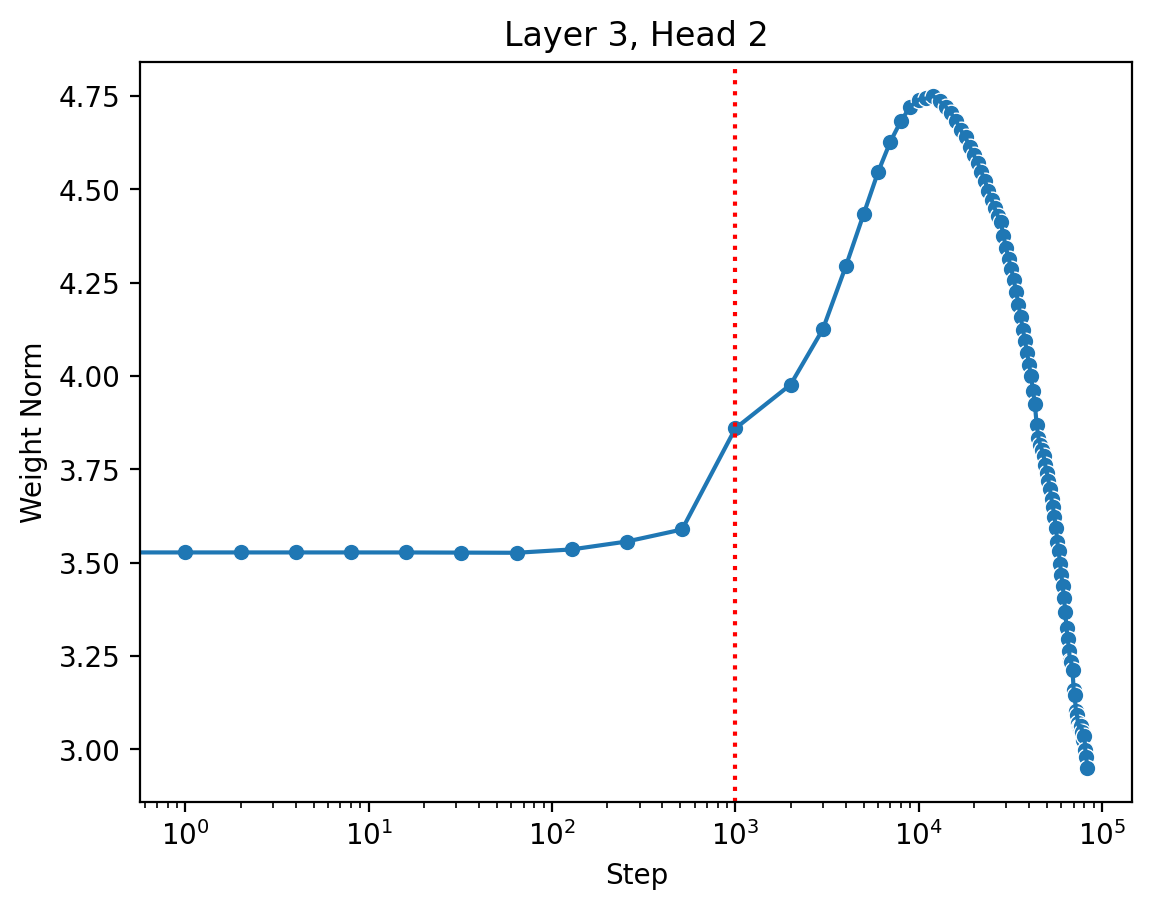

In [41]:
sns.lineplot(data = df_results,
             x = "step", y = "query_weight_norm")
sns.scatterplot(data = df_results,
             x = "step", y = "query_weight_norm")
plt.xscale('log')  # Use 'log' for log10 scaling
plt.title('Layer 3, Head 2')  # Use 'log' for log10 scaling
plt.ylabel("Weight Norm")
plt.xlabel("Step")
plt.axvline(x=1000, linestyle = "dotted", color = "red")

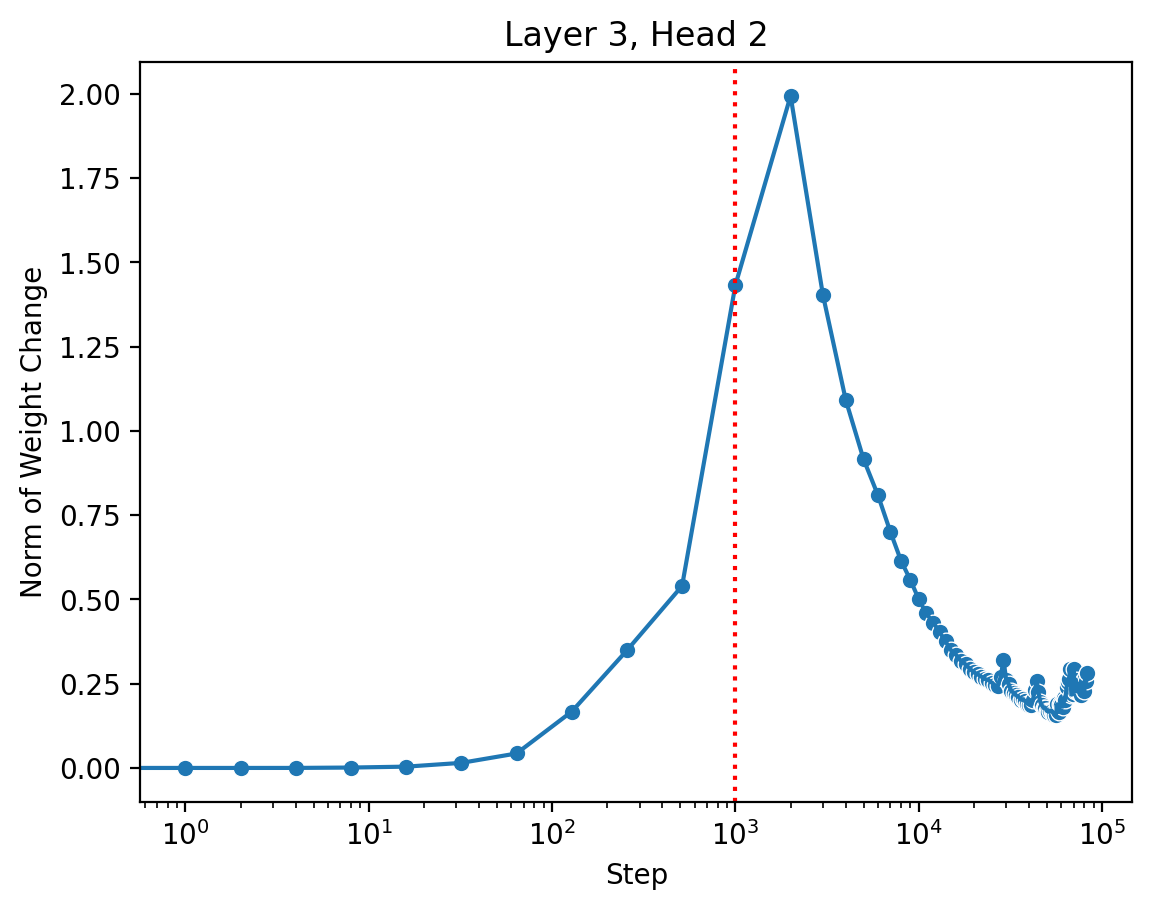

In [42]:
sns.lineplot(data = df_results,
             x = "step", y = "query_weight_change")
sns.scatterplot(data = df_results,
             x = "step", y = "query_weight_change")
plt.xscale('log')  # Use 'log' for log10 scaling
plt.title('Layer 3, Head 2')  # Use 'log' for log10 scaling
plt.ylabel("Norm of Weight Change")
plt.xlabel("Step")
plt.axvline(x=1000, linestyle = "dotted", color = "red")